In [1]:
import medmnist

In [19]:
import numpy as np

In [9]:
dataclass = getattr(medmnist, medmnist.INFO["breastmnist"]["python_class"])
train_data = dataclass(split="train", download=True)

Using downloaded and verified file: /home/hazem/.medmnist/breastmnist.npz


In [8]:
print(train_data.imgs.shape)

(546, 28, 28)


In [11]:
import numpy as np
alt_data = np.load("/home/hazem/.medmnist/breastmnist.npz")
print(*alt_data.keys())

train_images val_images test_images train_labels val_labels test_labels


In [2]:
import json
import os
def read_data(train_data_path, test_data_path):
    if not isinstance(test_data_path, list):
        test_data_path = [test_data_path, ]
    groups = []
    train_data = {}
    test_data = [{} for _ in test_data_path]
    train_files = os.listdir(train_data_path)
    train_files = [f for f in train_files if f.endswith(".json")]
    for f in train_files:
        file_path = os.path.join(train_data_path, f)
        with open(file_path, "r") as inf:
            cdata = json.load(inf)
        if "hierarchies" in cdata:
            groups.extend(cdata["hierarchies"])
        train_data.update(cdata["user_data"])
    for F, td in zip(test_data_path, test_data):
        test_files = os.listdir(F)
        test_files = [f for f in test_files if f.endswith(".json")]
        for f in test_files:
            file_path = os.path.join(F, f)
            with open(file_path, "r") as inf:
                cdata = json.load(inf)
            td.update(cdata["user_data"])
    clients = list(sorted(train_data.keys()))
    return clients, groups, train_data, test_data


In [3]:
clients, groups, train_data, test_data = read_data('../../code/FedReg/data/mnist_10000/data/train/', '../../code/FedReg/data/mnist_10000/data/valid/')


In [7]:
print(type(clients))
print(type(groups))
print(type(train_data))
print(type(test_data))
print(groups)


<class 'list'>
<class 'list'>
<class 'dict'>
<class 'list'>
[]


In [9]:
print(len(clients))
print(len(groups))
print(len(train_data))
print(len(test_data))

5000
0
5000
1


In [ ]:
clients, groups, train_data, test_data = read_data('../../code/FedReg/data/mnist_10000/data/train/', '../../code/FedReg/data/mnist_10000/data/valid/')


In [22]:
first_datax = np.array(train_data['f_00000']['x'])
first_datay = np.array(train_data['f_00000']['y'])

In [26]:
import matplotlib.pyplot as plt

In [25]:
print(first_datax.shape)
print(first_datay.shape)

(2, 784)
(2,)


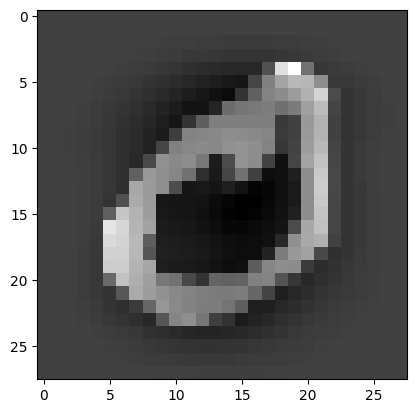

In [33]:
plt.imshow(first_datax[1].reshape((28,28,1)), cmap='gray')

In [35]:
len(test_data[0])


5000

In [ ]:
import medmnist
from torch.utils.data import TensorDataset
import torch
def download_dataset(ds_name, root=None):
    ds_name = ds_name.lower()
    assert ds_name in ["pathmnist", "chestmnist", "dermamnist", "octmnist", "pneumoniamnist", "retinamnist", "breastmnist", "bloodmnist",
     "tissuemnist", "organamnist", "organcmnist", "organsmnist"], "Dataset's name is not correct, please check the README for the available datasets"
    import medmnist
    from medmnist import INFO
    dataclass = getattr(medmnist, INFO[ds_name]["python_class"])
    if root == None:
        train_dataset = dataclass(split="train", download=True)
        test_dataset = dataclass(split="test", download=Truimgse)
    else:
        train_dataset = dataclass(root=root, split="train", download=True)
        test_dataset = dataclass(root=root, split="test", download=True)
    
    return train_dataset, test_dataset    
    

def load_dataset(data_path):
    # train_images val_images test_images train_labels val_labels test_labels
    data = np.load(data_path)
    train_dataset = TensorDataset(data["train_images"], data["train_labels"])
    test_dataset = TensorDataset(data["test_images"], data["test_labels"])
    return train_dataset, test_dataset    

In [67]:
import numpy as np


def read_data(ds_name=None,download=False,num_clients=5, data_path=None, iid=True):
    print(ds_name)
    print(download)
    print(num_clients)
    print(data_path)
    print(iid)
    def iid_partition(dataset, clients):
        """
        I.I.D paritioning of data over clients
        Shuffle the data
        Split it between clients

        params:
          - dataset (torch.utils.Dataset): Dataset containing the PathMNIST Images 
          - clients (int): Number of Clients to split the data between
        returns:
          - Dictionary of image indexes for each client
        """

        num_items_per_client = int(len(dataset)/clients)
        client_dict = {}
        image_idxs = [i for i in range(len(dataset))]

        for i in range(clients):
            client_dict[i] = set(np.random.choice(image_idxs, num_items_per_client, replace=False))
            image_idxs = list(set(image_idxs) - client_dict[i])
        return client_dict # client dict has [idx: list(datapoint indices)
    
    def non_iid_partition(dataset, num_clients):
        """
        non I.I.D parititioning of data over clients
        Sort the data by the digit label
        Divide the data into N shards of size S
        Each of the clients will get X shards

        params:
          - dataset (torch.utils.Dataset): Dataset containing the pathMNIST Images
          - num_clients (int): Number of Clients to split the data between
          - total_shards (int): Number of shards to partition the data in
          - shards_size (int): Size of each shard 
          - num_shards_per_client (int): Number of shards of size shards_size that each client receives

        returns:
          - Dictionary of image indexes for each client
        """
        shards_size = 9
        total_shards = len(dataset)// shards_size
        num_shards_per_client = total_shards // num_clients
        shard_idxs = [i for i in range(total_shards)]
        client_dict = {i: np.array([], dtype='int64') for i in range(num_clients)}
        idxs = np.arange(len(dataset))
        # get labels as a numpy array
        data_labels = np.array([target.numpy().flatten() for _, target in dataset]).flatten()
        # sort the labels
        label_idxs = np.vstack((idxs, data_labels))
        label_idxs = label_idxs[:, label_idxs[1,:].argsort()]
        idxs = label_idxs[0,:]

        # divide the data into total_shards of size shards_size
        # assign num_shards_per_client to each client
        for i in range(num_clients):
            rand_set = set(np.random.choice(shard_idxs, num_shards_per_client, replace=False))
            shard_idxs = list(set(shard_idxs) - rand_set)

            for rand in rand_set:
                client_dict[i] = np.concatenate((client_dict[i], idxs[rand*shards_size:(rand+1)*shards_size]), axis=0)
        return client_dict # client dict has [idx: list(datapoint indices)
    
    #### 
    assert not (download==False and data_path == None), "Either provide True for download or the data path"
    assert not (download == True and ds_name == None),  "Provide a dataset name please"
    
    # read_data(ds_name=None,download=False,num_clients=5, data_path=None)

    if download:
        train_dataset, test_dataset = download_dataset(ds_name=ds_name, root=data_path)
        print(type(train_dataset.imgs))
        print(type(train_dataset.labels))
        train_dataset = TensorDataset(torch.Tensor(train_dataset.imgs), torch.tensor(train_dataset.labels))
        test_dataset = TensorDataset(torch.Tensor(test_dataset.imgs), torch.tensor(test_dataset.labels))
    else:
        train_dataset, test_dataset = load_dataset(data_path)

    if iid:
        clients_dict = iid_partition(train_dataset, num_clients)
    else:
        clients_dict = non_iid_partition(train_dataset, num_clients)

    # groups mean hierarchies, will not implement for now
    groups = []

    return clients_dict.keys(), groups, clients_dict, test_dataset

In [27]:
clients, groups , clients_data, test_dataset = read_data(ds_name="breastmnist",download=True,num_clients=5, data_path="./data", iid=True)

breastmnist
True
5
./data
True


  0%|          | 0/559580 [00:00<?, ?it/s]

Using downloaded and verified file: ./data/breastmnist.npz
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [31]:
print("clients type:", type(clients), "length:", len(clients))
print("groups type:", type(groups), "length:", len(groups))
print("clients_data type:", type(clients_data), "length:", len(clients_data))
print("test_dataset type:", type(test_dataset), "length:", len(test_dataset))

clients type: <class 'dict_keys'> length: 5
groups type: <class 'list'> length: 0
clients_data type: <class 'dict'> length: 5
test_dataset type: <class 'torch.utils.data.dataset.TensorDataset'> length: 156


In [39]:
len(test_dataset)

156

In [35]:
print(sum([len(i) for i in clients_data.values()]))

545


In [68]:
!rm ./data/breastmnist.npz

In [69]:
nclients, ngroups , nclients_data, ntest_dataset = read_data(ds_name="breastmnist",download=True,num_clients=5, data_path="./data", iid=False)


breastmnist
True
5
./data
False


  0%|          | 0/559580 [00:00<?, ?it/s]

Using downloaded and verified file: ./data/breastmnist.npz
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [70]:
print("clients type:", type(nclients), "length:", len(nclients))
print("groups type:", type(ngroups), "length:", len(ngroups))
print("clients_data type:", type(nclients_data), "length:", len(nclients_data))
print("test_dataset type:", type(ntest_dataset), "length:", len(ntest_dataset))

clients type: <class 'dict_keys'> length: 5
groups type: <class 'list'> length: 0
clients_data type: <class 'dict'> length: 5
test_dataset type: <class 'torch.utils.data.dataset.TensorDataset'> length: 156


In [84]:
# train_images val_images test_images train_labels val_labels test_labels
data_all = np.load("./data/breastmnist.npz")
train_labels = np.unique(data_all["train_labels"], return_counts=True)
test_labels = np.unique(data_all["test_labels"], return_counts=True)
val_labels = np.unique(data_all["val_labels"], return_counts=True)

print("train_labels")
print(train_labels)
print(train_labels[1][0] / train_labels[1][1])
print("test_labels")
print(test_labels)
print(test_labels[1][0] / test_labels[1][1])
print("val_labels")
print(val_labels)
print(val_labels[1][0] / val_labels[1][1])

train_labels
(array([0, 1], dtype=uint8), array([147, 399]))
0.3684210526315789
test_labels
(array([0, 1], dtype=uint8), array([ 42, 114]))
0.3684210526315789
val_labels
(array([0, 1], dtype=uint8), array([21, 57]))
0.3684210526315789
